##🚀drive mounting

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/NeuralNet/Homework1/final

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1NEMIgOvlKnEmQ3ka0lMKmmV7tpoGZaMt/NeuralNet/Homework1/final


##📚importing libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

import tensorflow as tf
from tensorflow import keras as tfk
#import keras as tfk       #notice how I'm importing keras and not tensorflow.keras
#from keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print(f"Tensorflow version -> {tf.__version__}")
print(f"Keras version -> {tfk.__version__}")
# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
from PIL import Image
import matplotlib.gridspec as gridspec
import os

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

Tensorflow version -> 2.17.1
Keras version -> 3.5.0
2.17.1


##📊Dataset

In previous explorations of the dataset we found some outliers and we decided to definitively remove them from out dataset

In [ ]:
data = np.load('./training_set.npz')
X_import= data['images']
y_import = data['labels']
X=X_import[:11958]
y=y_import[:11958]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (11958, 96, 96, 3)
y shape: (11958, 1)


###visual inspection

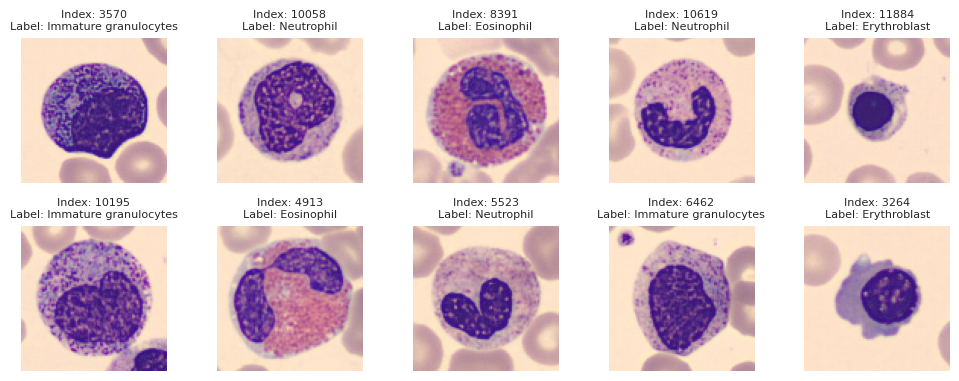

In [ ]:
# Define labels for each class
labels = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

# Number of images to display
num_images_to_display = 10

# Generate 10 random indices from the range of available data
random_indices = np.random.choice(min(len(X), len(y)), num_images_to_display, replace=False)

# Set up a 2x5 grid for displaying images
fig, axs = plt.subplots(2, 5, figsize=(10, 4))  # 2 rows, 5 columns

for idx, i in enumerate(random_indices):
    row = idx // 5  # Determine row index (0 or 1)
    col = idx % 5   # Determine column index (0 to 4)

    axs[row, col].imshow(np.squeeze(X[i]), vmin=0., vmax=1.)
    axs[row, col].set_title(f'Index: {i}\nLabel: {labels[y[i][0]]}', fontsize=8)
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# get shapes for each class
for class_idx, class_name in enumerate(labels):
    # Filter y for the current class index
    y_class = y[y == class_idx]
    print(f"Numerosity of {class_name} images: {y_class.shape}")


Numerosity of Basophil images: (852,)
Numerosity of Eosinophil images: (2181,)
Numerosity of Erythroblast images: (1085,)
Numerosity of Immature granulocytes images: (2026,)
Numerosity of Lymphocyte images: (848,)
Numerosity of Monocyte images: (993,)
Numerosity of Neutrophil images: (2330,)
Numerosity of Platelet images: (1643,)


###data processing

In [ ]:
# Normalize data to the range [0, 1]
X= (X / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y = tfk.utils.to_categorical(y)

In [ ]:
# Data splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (9685, 96, 96, 3)
Training Label Shape: (9685, 8)
Validation Data Shape: (1077, 96, 96, 3)
Validation Label Shape: (1077, 8)


In [ ]:
# Freeing the memory
import gc
del X, y

gc.collect()

26

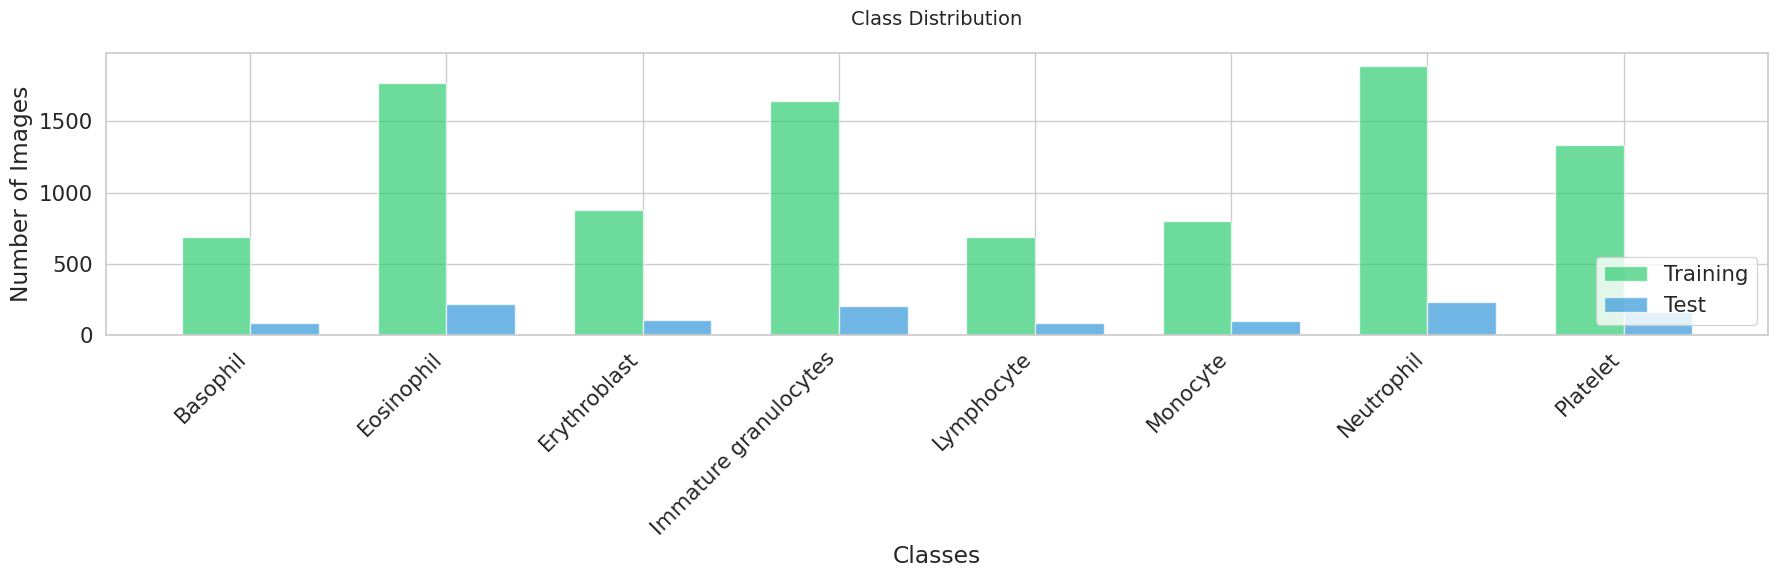

In [ ]:
def plot_class_distribution(y_train, y_test, class_names):
    # Set seaborn style for the plot
    sns.set_style("whitegrid")
    plt.figure(figsize=(18, 6))

    # Convert one-hot encoded labels back to class indices
    y_train_indices = np.argmax(y_train, axis=1)  # Get class indices from one-hot encoded labels
    y_test_indices = np.argmax(y_test, axis=1)    # Get class indices from one-hot encoded labels


    # Calculate class distributions for training and test sets
    train_dist = np.bincount(y_train_indices) # Use class indices for bincount
    test_dist = np.bincount(y_test_indices)   # Use class indices for bincount

    # Create x positions and set bar width
    x = np.arange(len(class_names))
    width = 0.35

    # Plot bars for training and test distributions
    plt.bar(x - width / 2, train_dist, width, label='Training', color='#2ecc71', alpha=0.7)
    plt.bar(x + width / 2, test_dist, width, label='Test', color='#3498db', alpha=0.7)

    # Customise plot title and labels
    plt.title('Class Distribution', pad=20, fontsize=14)
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')

    # Set class names as x-axis labels with rotation
    plt.xticks(x, class_names, rotation=45, ha='right')

    # Add legend for training and test distributions
    plt.legend(loc='lower right')

    # Adjust layout for optimal spacing
    plt.tight_layout()
    plt.show()

# Execute function to plot class distribution
plot_class_distribution(y_train, y_test, labels)

In [ ]:
#Check class numerosity
# Get shapes for each class in y_train
for class_idx, class_name in enumerate(labels):
    # Filter y_train for the current class index by checking if the one-hot column is 1
    y_class_train = y_train[np.argmax(y_train, axis=1) == class_idx]
    print(f"Numerosity of {class_name} images in training set: {y_class_train.shape[0]}")

print("\n")

Numerosity of Basophil images in training set: 690
Numerosity of Eosinophil images in training set: 1767
Numerosity of Erythroblast images in training set: 878
Numerosity of Immature granulocytes images in training set: 1641
Numerosity of Lymphocyte images in training set: 687
Numerosity of Monocyte images in training set: 804
Numerosity of Neutrophil images in training set: 1887
Numerosity of Platelet images in training set: 1331




###balancing data using synthetic data

Since the number of images is very different across classes, by applying transformations to the images of each class, we balance the class distribution to match the size of the largest class

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
import random

# Calculate the target count based on the most numerous class in `y_train`
unique, counts = np.unique(y_train.argmax(axis=1), return_counts=True)
class_counts = dict(zip(unique, counts))
target_count = max(class_counts.values())

# Initialize the data generator with augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    #rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Prepare lists to store the augmented images and labels
augmented_images = []
augmented_labels = []

# Augment underrepresented classes in `X_train` until each reaches the target count
for class_label, count in class_counts.items():
    if count < target_count:
        # Filter `X_train` to get only images of the current class
        indices = np.where(y_train.argmax(axis=1) == class_label)[0]
        X_train_class = X_train[indices]

        # Calculate the number of augmentations needed
        num_augmentations = target_count - count

        i = 0
        while i < num_augmentations:
            # Randomly select an image from `X_train_class`
            img = random.choice(X_train_class)
            x = img.reshape((1,) + img.shape)  # Reshape to add batch dimension

            # Generate one augmented image
            for batch in datagen.flow(x, batch_size=1):
                augmented_images.append(batch[0])  # Add augmented image
                augmented_labels.append(class_label)  # Add class label
                i += 1
                break  # Generate only one augmented image per selected image

# Convert augmented data to NumPy arrays
augmented_images = np.array(augmented_images)
# Convert `augmented_labels` to one-hot encoding to match `y_train` shape
augmented_labels = to_categorical(augmented_labels, num_classes=y_train.shape[1])

# Append the augmented images and labels back to `X_train` and `y_train`
X_train_balanced = np.concatenate((X_train, augmented_images), axis=0)
y_train_balanced = np.concatenate((y_train, augmented_labels), axis=0)

# Verify the new class counts in `y_train_balanced`
unique_balanced, counts_balanced = np.unique(y_train_balanced.argmax(axis=1), return_counts=True)
class_counts_balanced = dict(zip(unique_balanced, counts_balanced))

# Print the final shape and counts of each class in `X_train_balanced`
print("Class counts after balancing:")
for class_label, count in class_counts_balanced.items():
    print(f"Class {class_label}: {count}")
print("\nFinal shapes:")
print(f"X_train_balanced shape: {X_train_balanced.shape}")
print(f"y_train_balanced shape: {y_train_balanced.shape}")


Class counts after balancing:
Class 0: 1887
Class 1: 1887
Class 2: 1887
Class 3: 1887
Class 4: 1887
Class 5: 1887
Class 6: 1887
Class 7: 1887

Final shapes:
X_train_balanced shape: (15096, 96, 96, 3)
y_train_balanced shape: (15096, 8)


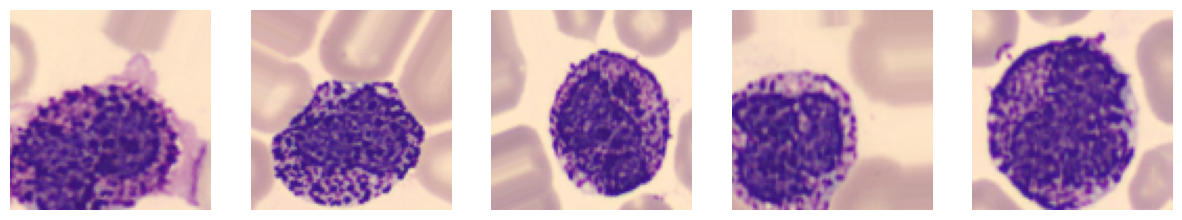

In [ ]:
# Check if the augmentation is reliable
# Display the first 5 augmented images to verify
num_images_to_display = 5
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 15))

for i in range(num_images_to_display):
    # Multiply by 255 to bring pixel values back to [0, 255] range for display
    axes[i].imshow(augmented_images[i])
    axes[i].axis('off')

plt.show()

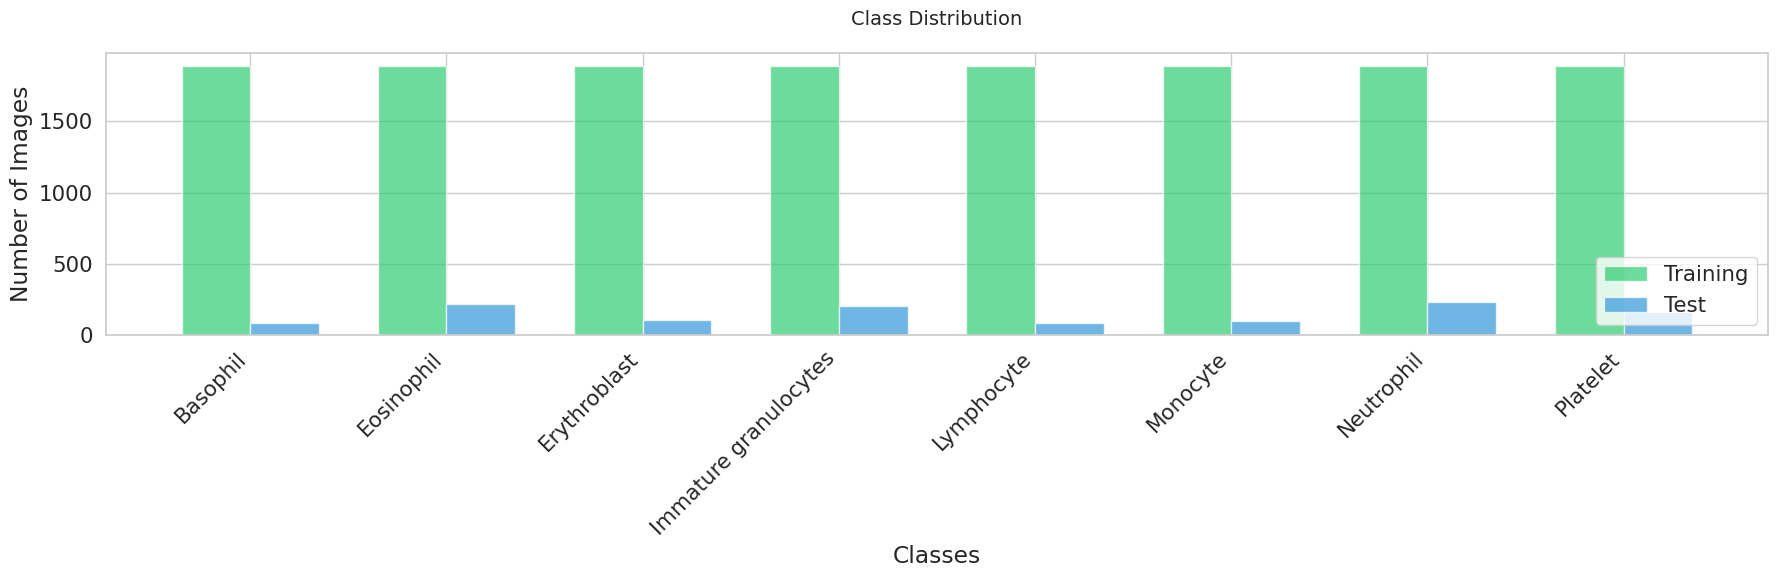

In [ ]:
# Execute function to plot new class distribution
plot_class_distribution(y_train_balanced, y_test, labels)

We can now see how each class is represented with the same number of images in the training set


In [ ]:
import gc

# Freeing the memory
del X_train
del augmented_images
del augmented_labels
gc.collect()

0

In [ ]:
# Input shape for the model
input_shape = X_train_balanced.shape[1:]

# Output shape for the model
output_shape = y_train.shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [ ]:
!pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 43.0 MB/s eta 0:00:00


###preparing the dataset

Prepare the training dataset by applying RandAugment to the images, and the validation dataset (also setting the batch size)

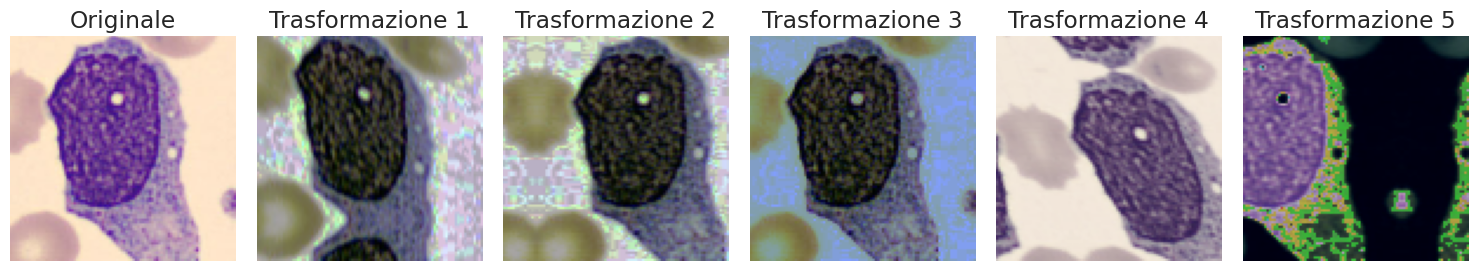

In [ ]:
import keras_cv

augmentation_layers = keras_cv.layers.RandAugment(
    value_range=(0, 255),  #It has to fit the image range
    augmentations_per_image=3,  #Transformations per image
    magnitude=0.3,  #Magnitude of the transformation
    magnitude_stddev=0.15,  #Standard deviation of the magnitude
    rate=1.0,  # Probability of applying the transformation
    geometric=True,
)


image=X_train_balanced[:5]*255
# Applies the augmentation pipeline to the image
augmented_images = []
for _ in range(5):  # Generates 5 transformations to visualize the variations
    augmented_image = augmentation_layers(image, training=True)
    augmented_images.append(augmented_image[0].numpy())  # Adds the transformation to the list

# Displays the images
plt.figure(figsize=(15, 5))

# Displays the original image
plt.subplot(1, 6, 1)
plt.imshow(image[0].astype(np.uint8))
plt.title("Originale")
plt.axis('off')

# Displays the transformed images
for i, aug_img in enumerate(augmented_images):
    plt.subplot(1, 6, i + 2)
    plt.imshow(aug_img.astype(np.uint8))
    plt.title(f"Trasformazione {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Freeing the memory
del augmentation_layers

gc.collect()

18063

In [ ]:
import tensorflow as tf
import keras_cv

# Defines RandAugment with parameters:
rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),  # Adjusts the image range (0-255)
    augmentations_per_image=3,  # Number of transformations per image
    magnitude=0.3,  # Intensity of the transformations
    magnitude_stddev=0.15,  # Standard deviation for magnitude
    rate=1.0,  # Probability of applying each transformation
)

# Creation of the datasets
batch_size = 32

train_ds = tf.data.Dataset.from_tensor_slices((X_train_balanced*255, y_train_balanced))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_val*255, y_val))

train_ds = train_ds.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

# Function to apply RandAugment
def apply_rand_augment(images, labels):
    images = rand_augment(images)  # Applies RandAugment only to the images
    return images, labels

# Applies RandAugment to the training dataset
train_ds = train_ds.map(apply_rand_augment, num_parallel_calls=tf.data.AUTOTUNE)

# Preprocessing function to normalize the images
def preprocess_for_model(images, labels):
    images = tf.cast(images, tf.float32)
    labels=tf.cast(labels, tf.float32)
    return images, labels

# Preprocessing on the datasets
train_ds = train_ds.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(preprocess_for_model, num_parallel_calls=tf.data.AUTOTUNE)

# Optimizations
train_ds = train_ds.cache()  # Caches in memory
train_ds = train_ds.shuffle(buffer_size=1000)  # Shuffles the dataset
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetches the batches
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

##💡VGG16

###transfer learning

We apply transfer learning: we import the VGG16 model, pre-trained on the Imagenet dataset, freezing all parameters of all layers, but excluding the final classification layer.
From this base model, we build our model by adding a Lambda layer between the input and the VGG16 model, then adding a GAP layer, a Dropout layer and the final Dense classification layer at the output of the imported model.
We use Categorical Crossentropy as the loss function and Adam as the optimizer


In [ ]:
from keras.applications import VGG16
import keras_cv

vgg=VGG16(include_top=False, weights='imagenet', input_shape=(96, 96, 3)) # Import the VGG16 model
vgg.trainable=False # Freeze all layers for initial transfer learning


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg_preprocessing (Lambda)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,718,792 (56.15 MB)

 Trainable params: 4,104 (16.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

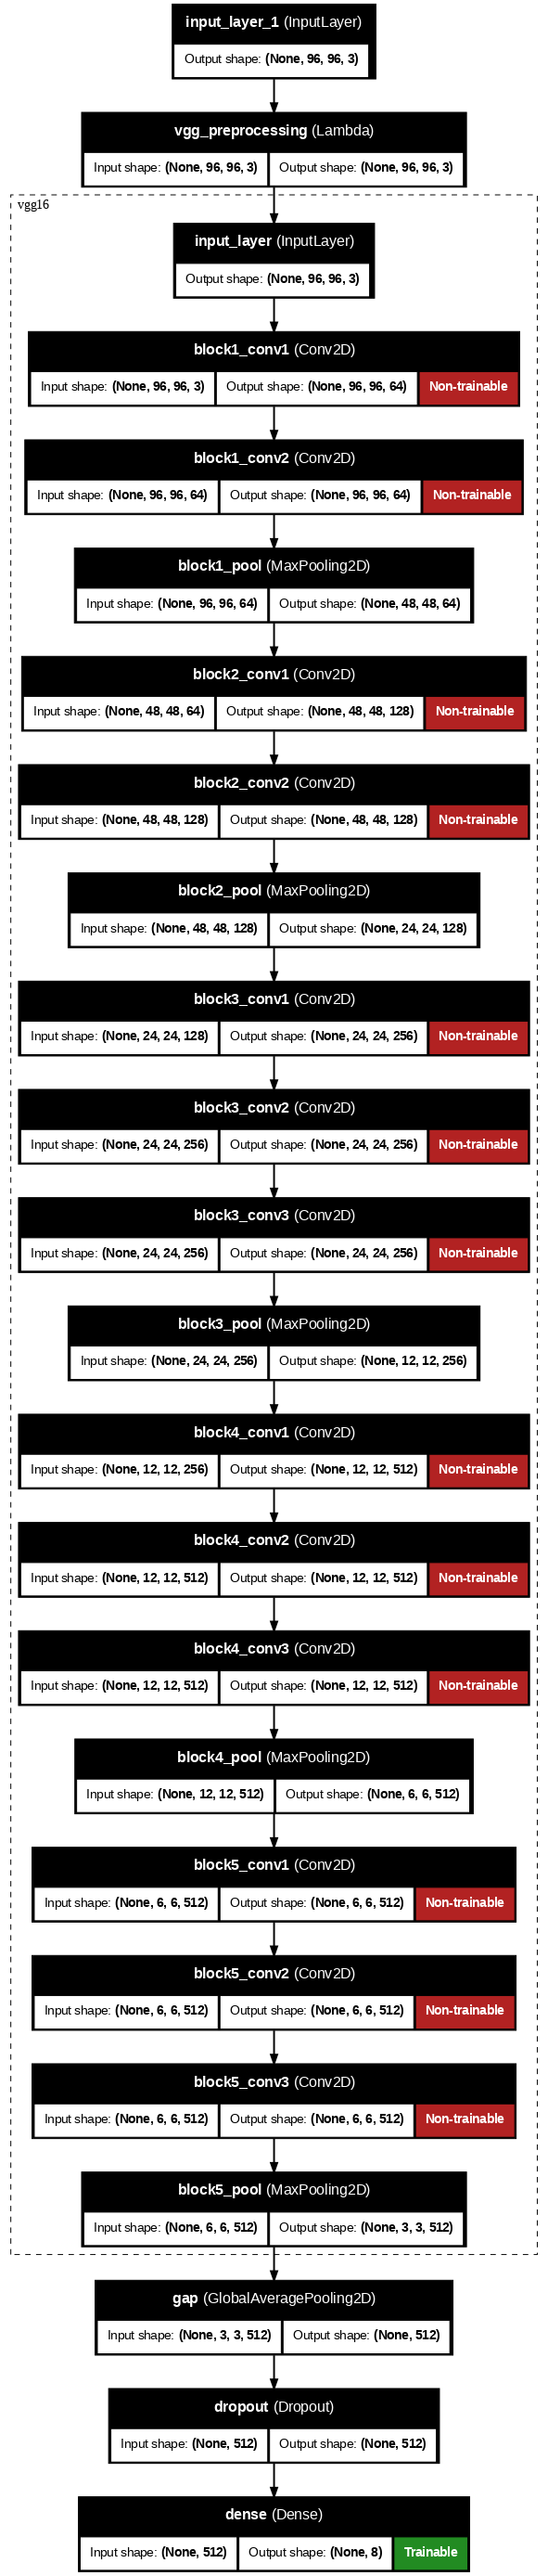

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers, models

inputs = layers.Input(shape=(96, 96, 3))
x = tf.keras.layers.Lambda(tf.keras.applications.vgg16.preprocess_input, name="vgg_preprocessing")(inputs) #https://keras.io/api/applications/vgg/
x = vgg(x)

# Add GlobalAveragePooling and Dropout
x = tfkl.GlobalAveragePooling2D(name='gap')(x)
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add a final Dense layer for classification
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Create the model
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')
model = models.Model(inputs, outputs)

# Compile the model with categorical cross-entropy loss and Adam optimiser
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

#Display model summary
model.summary(expand_nested=True)


# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, show_layer_names=True, dpi=70)

Above, you can see the structure of the created model and the number of parameters

We can train the model, also using early stopping to prevent overfitting and reduce computational time

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    epochs=1000,
    validation_data=validation_dataset,
    callbacks=[tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

# Calculate and print the best validation accuracy achieved
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file, including final accuracy in the filename
model_filename = 'bloodcells_vgg_' + str(final_val_accuracy) + '.keras'
model.save(model_filename)
print(f"Model saved as {model_filename}")

# Free memory by deleting the model instance
del model

Epoch 1/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 106s 45ms/step - accuracy: 0.2582 - loss: 8.6546 - val_accuracy: 0.5487 - val_loss: 1.5540
Epoch 2/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 53s 31ms/step - accuracy: 0.4644 - loss: 2.9609 - val_accuracy: 0.7084 - val_loss: 0.8511
Epoch 3/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5342 - loss: 1.9372 - val_accuracy: 0.6453 - val_loss: 0.9556
Epoch 4/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 29ms/step - accuracy: 0.5650 - loss: 1.6653 - val_accuracy: 0.6871 - val_loss: 0.8822
Epoch 5/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.5445 - loss: 1.5682 - val_accuracy: 0.6481 - val_loss: 0.9504
Epoch 6/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - accuracy: 0.5775 - loss: 1.4729 - val_accuracy: 0.6537 - val_loss: 1.1782
Epoch 7/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.5446 - loss: 1.5966 - val_accuracy: 0.6472 - val_loss: 1.0050
Epoch 8/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.5757 

###fine tuning

Now let's proceed with fine-tuning: from the previously trained model, we freeze only the first 15 layers, allowing all the other parameters to be trained.
The loss function remains the same, while we continue using Adam as the optimizer, but with a smaller learning rate

####freezing 15 layers

loading bloodcells_vgg_72.79.keras


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg_preprocessing (Lambda)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,727,002 (56.18 MB)

 Trainable params: 4,104 (16.03 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 8,210 (32.07 KB)

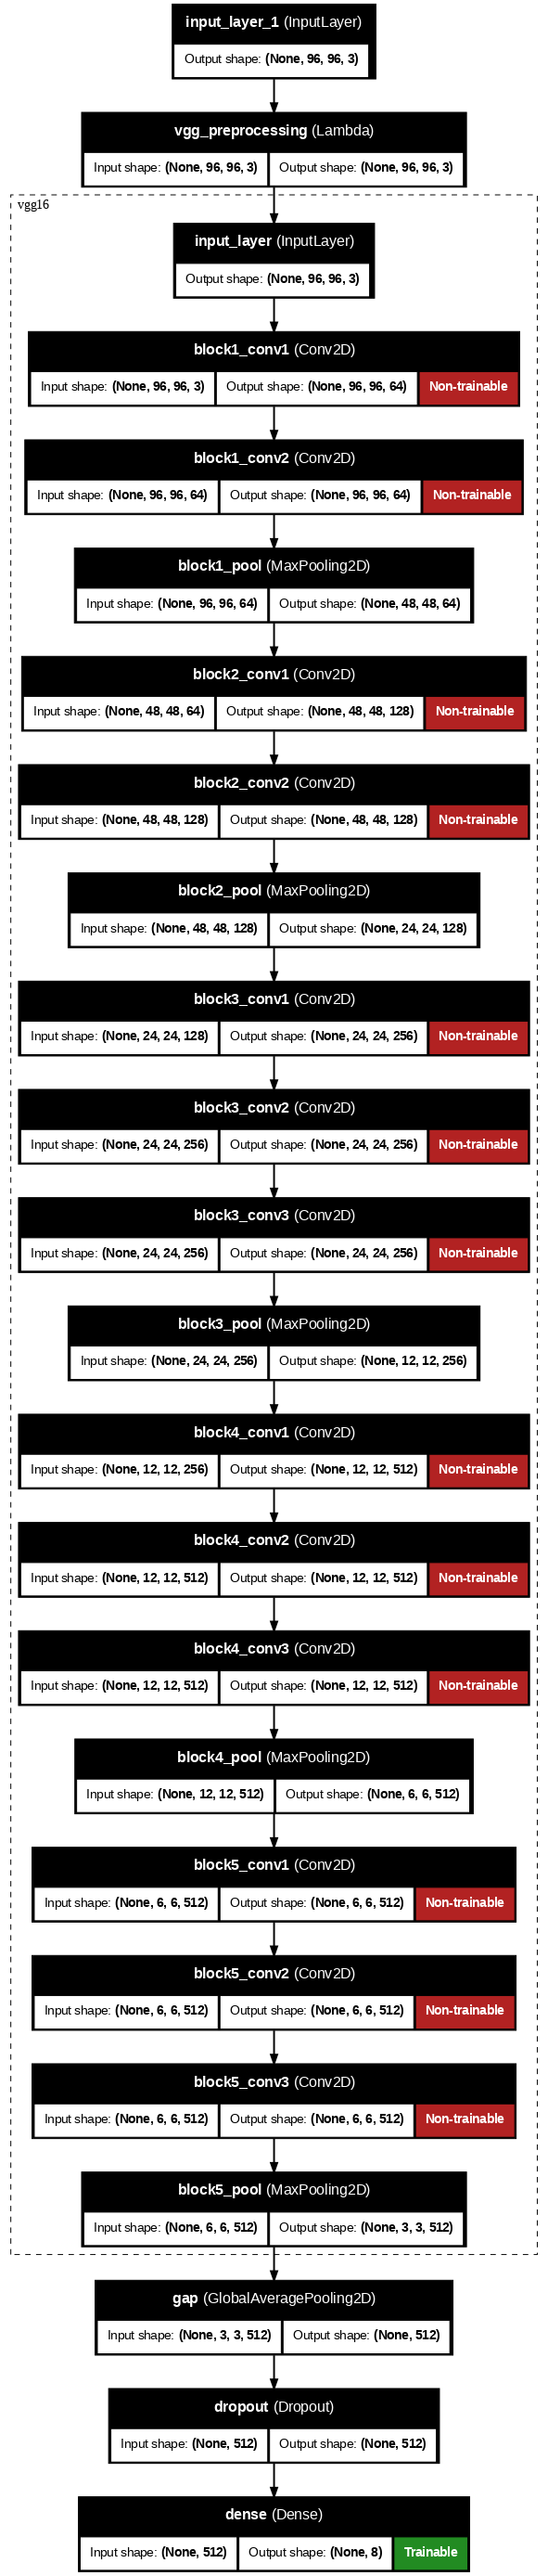

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input

# model_filename = 'bloodcells_vgg_' + str(final_val_accuracy) + '.keras'
print("loading " + model_filename)
model = load_model(model_filename,custom_objects={"preprocess_input": preprocess_input}) # Load the pre-trained model

#Display summary
model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, show_layer_names=True, dpi=70)

0 input_layer False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool False


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg_preprocessing (Lambda)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,727,002 (56.18 MB)

 Trainable params: 7,083,528 (27.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 8,210 (32.07 KB)

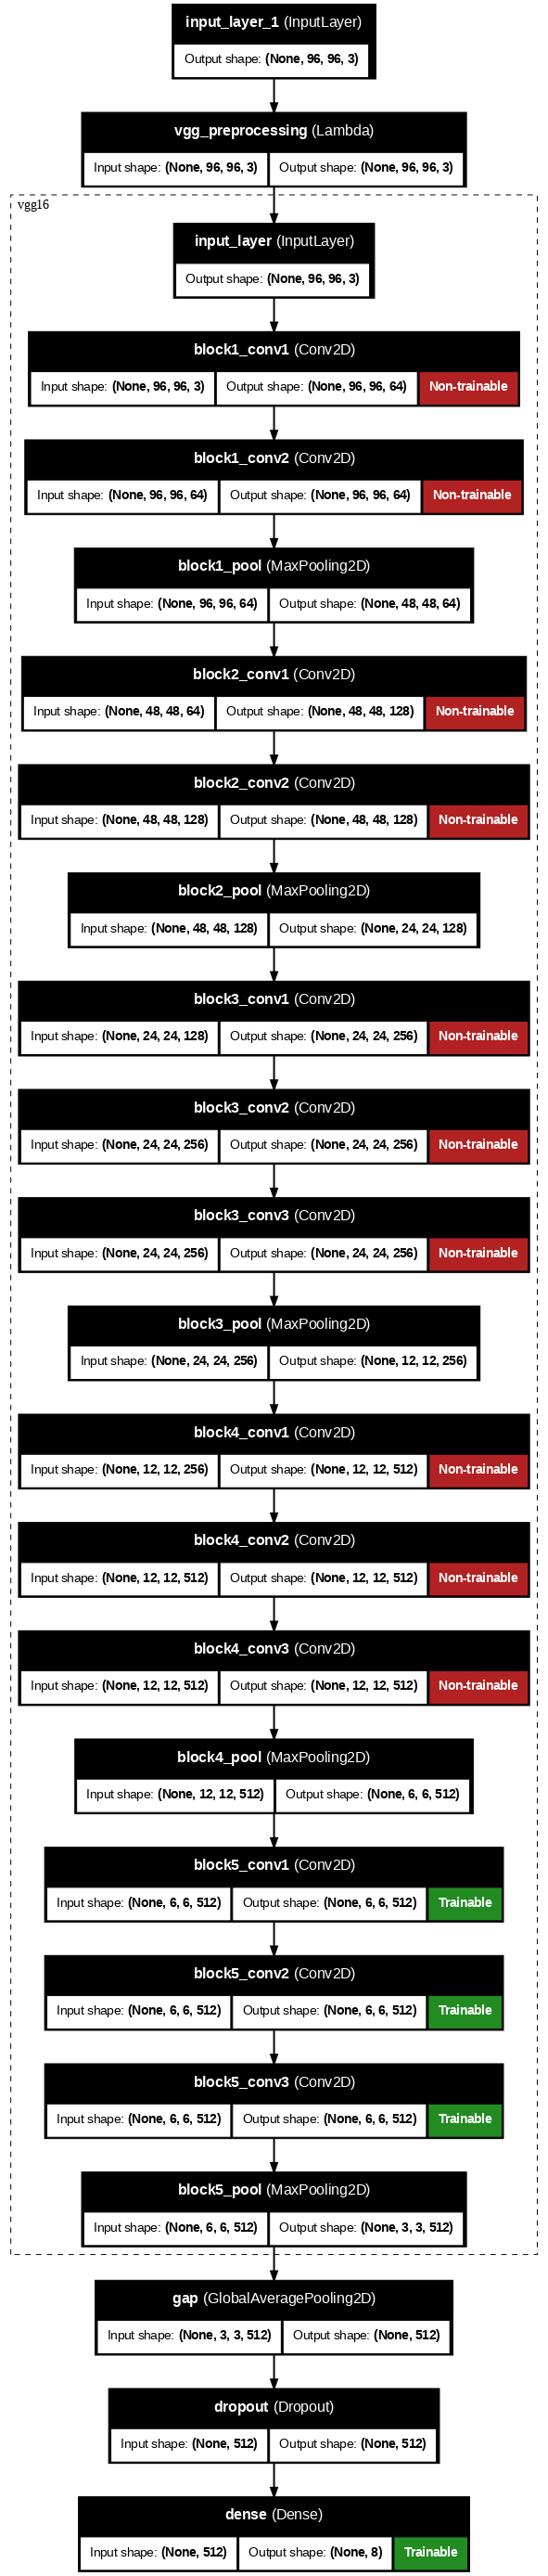

In [ ]:
# Set all layers in vgg16 as trainable
model.get_layer('vgg16').trainable = True

# Set all layers as non-trainable
for layer in model.get_layer('vgg16').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(model.get_layer('vgg16').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
       # print(i, layer.name, type(layer).__name__, layer.trainable)

# Set the number of layers to freeze
N = 15

# Set the first N layers as non-trainable
for i, layer in enumerate(model.get_layer('vgg16').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(model.get_layer('vgg16').layers):
    print(i, layer.name, layer.trainable)


model.summary(expand_nested=True)


# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, show_layer_names=True, dpi=70)

Above, we can see which layers are frozen and which are now trainable, along with the number of trainable and non-trainable parameters

In [ ]:
# Define the patience value for early stopping
patience = 20

# Create an EarlyStopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True,
)

# Store the callback in a list
callbacks = [early_stopping]

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg_preprocessing (Lambda)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,718,792 (56.15 MB)

 Trainable params: 7,083,528 (27.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

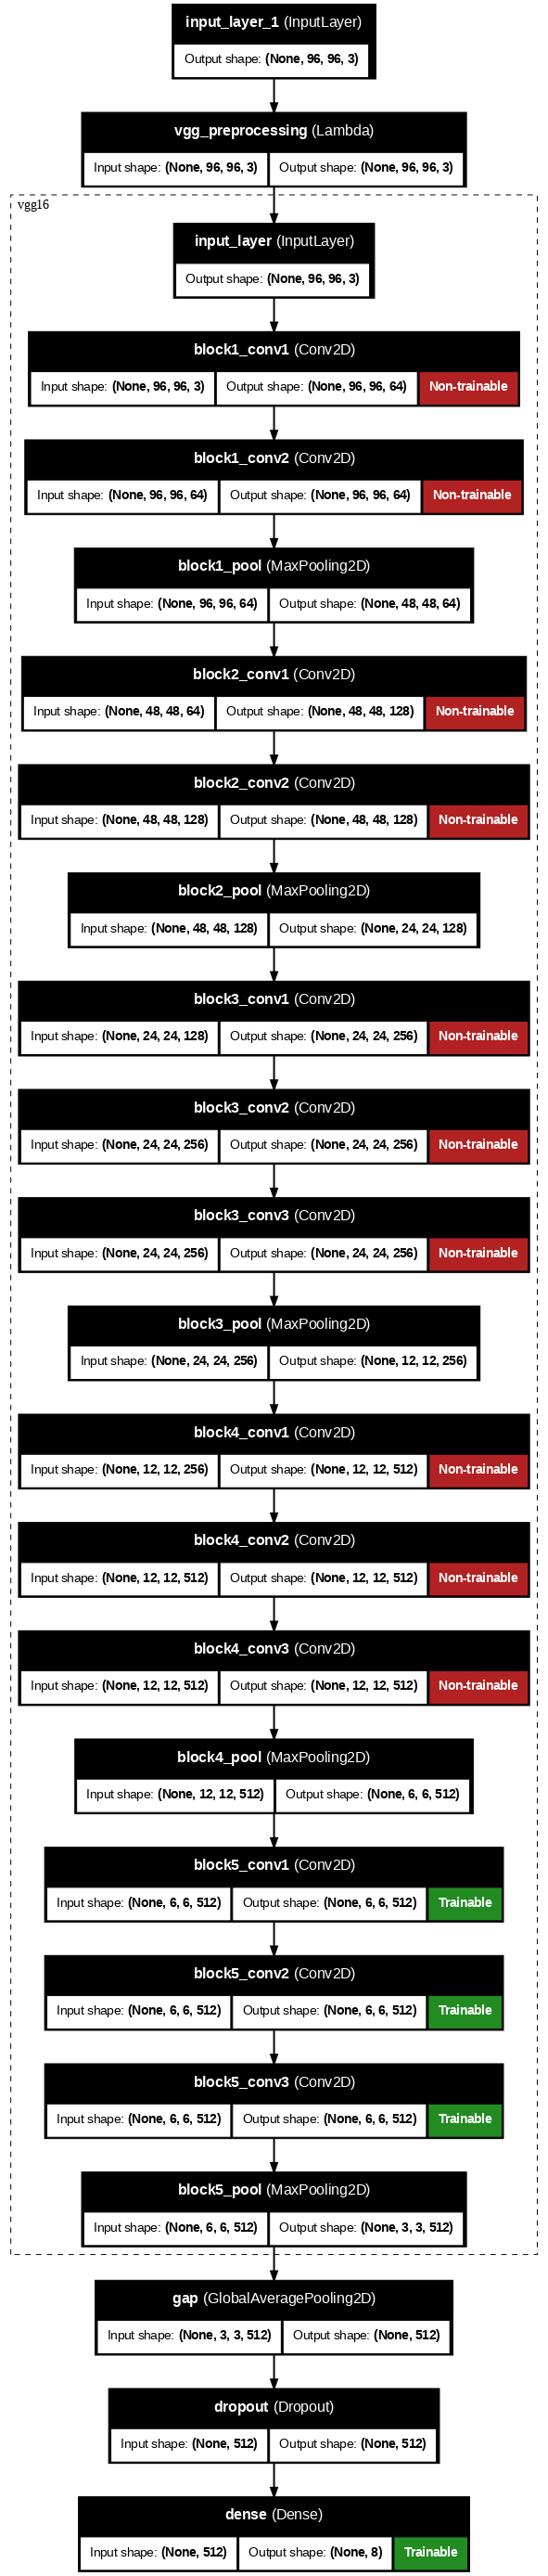

In [ ]:
# Compile the model
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy'])

# Display a summary of the model architecture
model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, show_layer_names=True, dpi=70)

In [ ]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=validation_dataset,
    epochs=1000,
    callbacks=callbacks
).history


# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy']) * 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Format the filename to avoid special character issues
# Replace decimal point in accuracy with underscore, or convert to an integer
formatted_accuracy = str(final_val_accuracy).replace('.', '_')
model_filename = f'VGG_15layers_{formatted_accuracy}.keras'

# Save model to the Homework directory
model.save(model_filename)
print(f"Model saved as {model_filename}")

Epoch 1/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 121s 59ms/step - accuracy: 0.5652 - loss: 1.2274 - val_accuracy: 0.8468 - val_loss: 0.3823
Epoch 2/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.8162 - loss: 0.5352 - val_accuracy: 0.9081 - val_loss: 0.2795
Epoch 3/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.8748 - loss: 0.3483 - val_accuracy: 0.8468 - val_loss: 0.3993
Epoch 4/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9127 - loss: 0.2515 - val_accuracy: 0.9489 - val_loss: 0.1700
Epoch 5/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.9432 - loss: 0.1720 - val_accuracy: 0.9406 - val_loss: 0.1947
Epoch 6/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9593 - loss: 0.1139 - val_accuracy: 0.9629 - val_loss: 0.1418
Epoch 7/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9675 - loss: 0.0900 - val_accuracy: 0.9443 - val_loss: 0.2446
Epoch 8/1000
472/472 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9506 

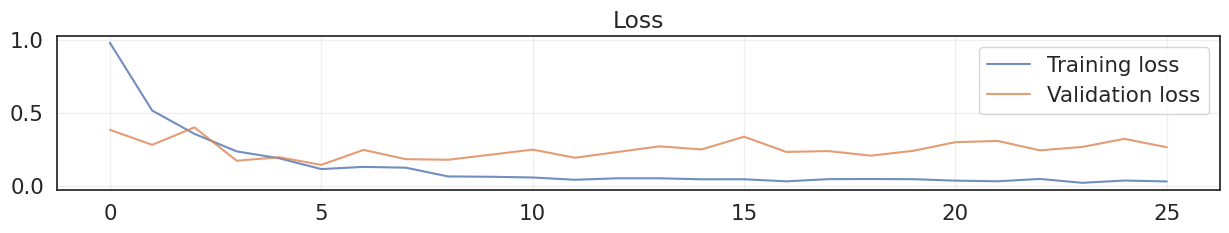

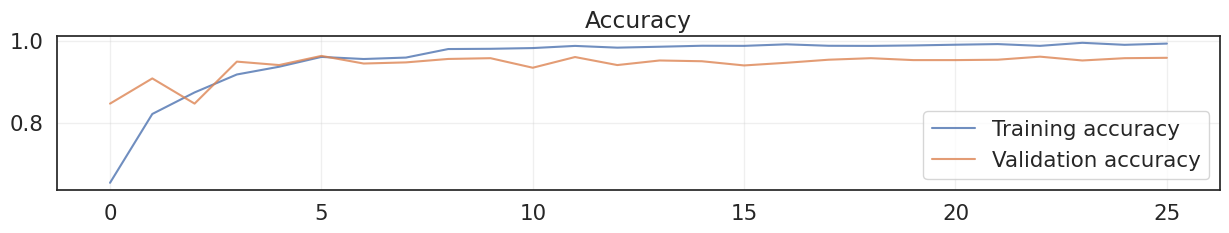

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

Above, you can see the progress of the Loss function and of the accuracy for both Training and Validation during the model training

#####make inference

We can now use the trained model to see how it performs on a test dataset, never seen by the model before

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)                        ┃ Output Shape                 ┃       Param # ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1 (InputLayer)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ vgg_preprocessing (Lambda)          │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│ vgg16 (Functional)                  │ (None, 3, 3, 512)            │    14,714,688 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ input_layer (InputLayer)       │ (None, 96, 96, 3)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1_conv1 (Conv2D)          │ (None, 96, 96, 64)           │         1,792 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1_conv2 (Conv2D)          │ (None, 96, 96, 64)           │        36,928 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block1_pool (MaxPooling2D)     │ (None, 48, 48, 64)           │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block2_conv1 (Conv2D)          │ (None, 48, 48, 128)          │        73,856 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block2_conv2 (Conv2D)          │ (None, 48, 48, 128)          │       147,584 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block2_pool (MaxPooling2D)     │ (None, 24, 24, 128)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block3_conv1 (Conv2D)          │ (None, 24, 24, 256)          │       295,168 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block3_conv2 (Conv2D)          │ (None, 24, 24, 256)          │       590,080 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block3_conv3 (Conv2D)          │ (None, 24, 24, 256)          │       590,080 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block3_pool (MaxPooling2D)     │ (None, 12, 12, 256)          │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block4_conv1 (Conv2D)          │ (None, 12, 12, 512)          │     1,180,160 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block4_conv2 (Conv2D)          │ (None, 12, 12, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block4_conv3 (Conv2D)          │ (None, 12, 12, 512)          │     2,359,808 │    N    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block4_pool (MaxPooling2D)     │ (None, 6, 6, 512)            │             0 │    -    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block5_conv1 (Conv2D)          │ (None, 6, 6, 512)            │     2,359,808 │    Y    │
├─────────────────────────────────────┼──────────────────────────────┼───────────────┼─────────┤
│    └ block5_conv2 (Co

 Total params: 28,885,850 (110.19 MB)

 Trainable params: 7,083,528 (27.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 14,167,058 (54.04 MB)

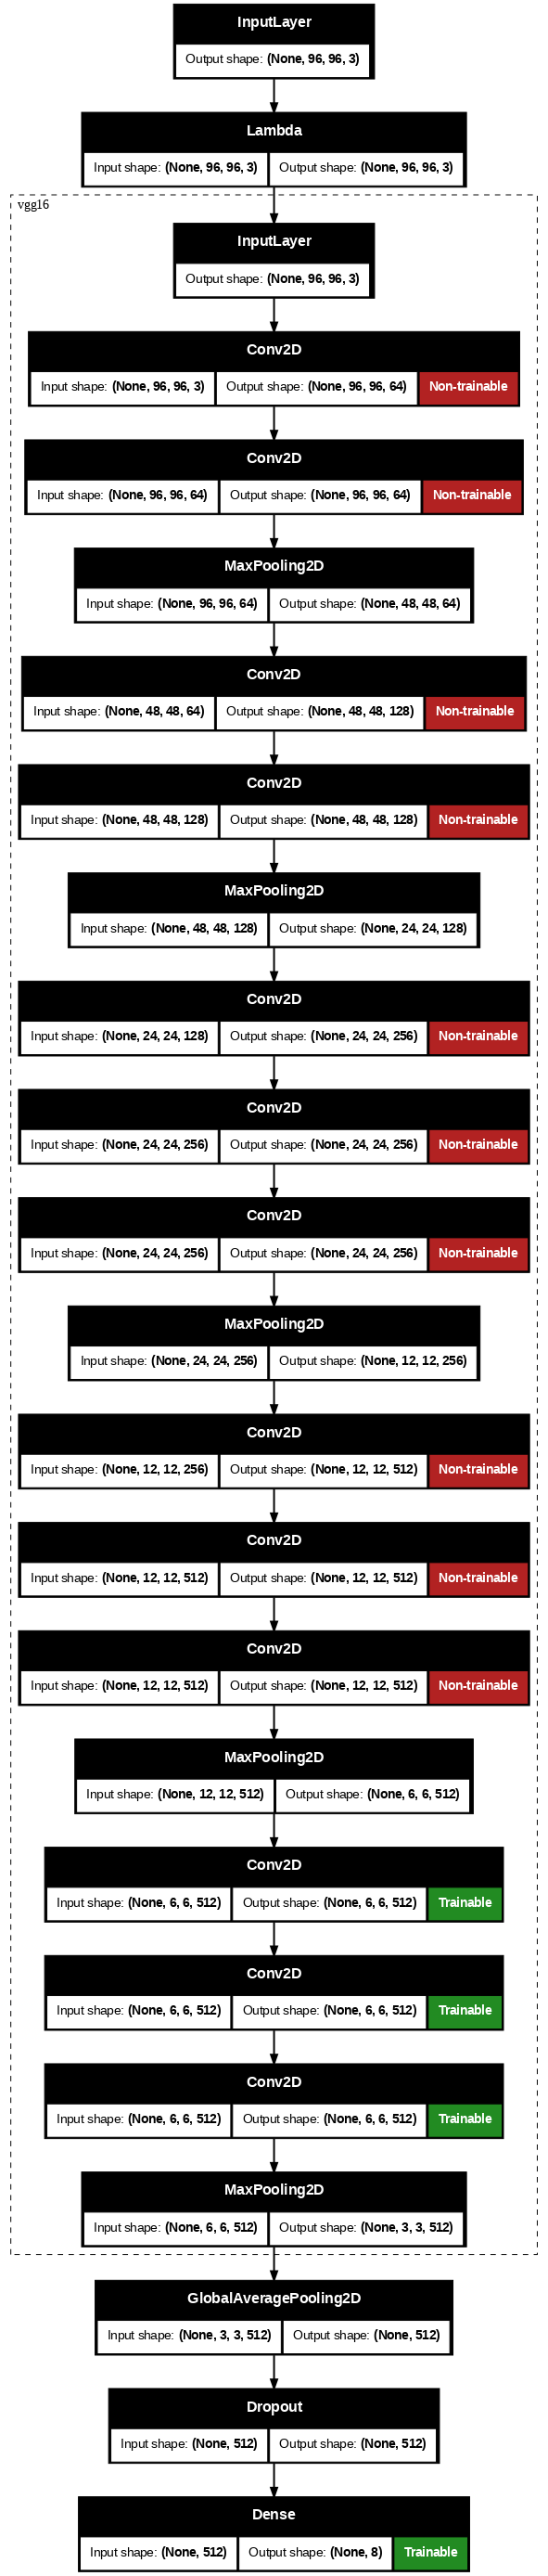

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

# Load the saved model
# model_filename = f'VGG_15layers_{formatted_accuracy}.keras'
model_filename="VGG_15layers_96_29.keras"
model = tfk.models.load_model(model_filename, custom_objects={"preprocess_input": preprocess_input})

# Display a summary of the model architecture
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True,  dpi=70)

In [ ]:
# Predict labels for the entire test set
predictions = model.predict(X_test*255, verbose=0)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

Predictions Shape: (1196, 8)


In [ ]:
labels = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

Accuracy score over the test set: 0.9473
Precision score over the test set: 0.9485
Recall score over the test set: 0.9473
F1 score over the test set: 0.9474


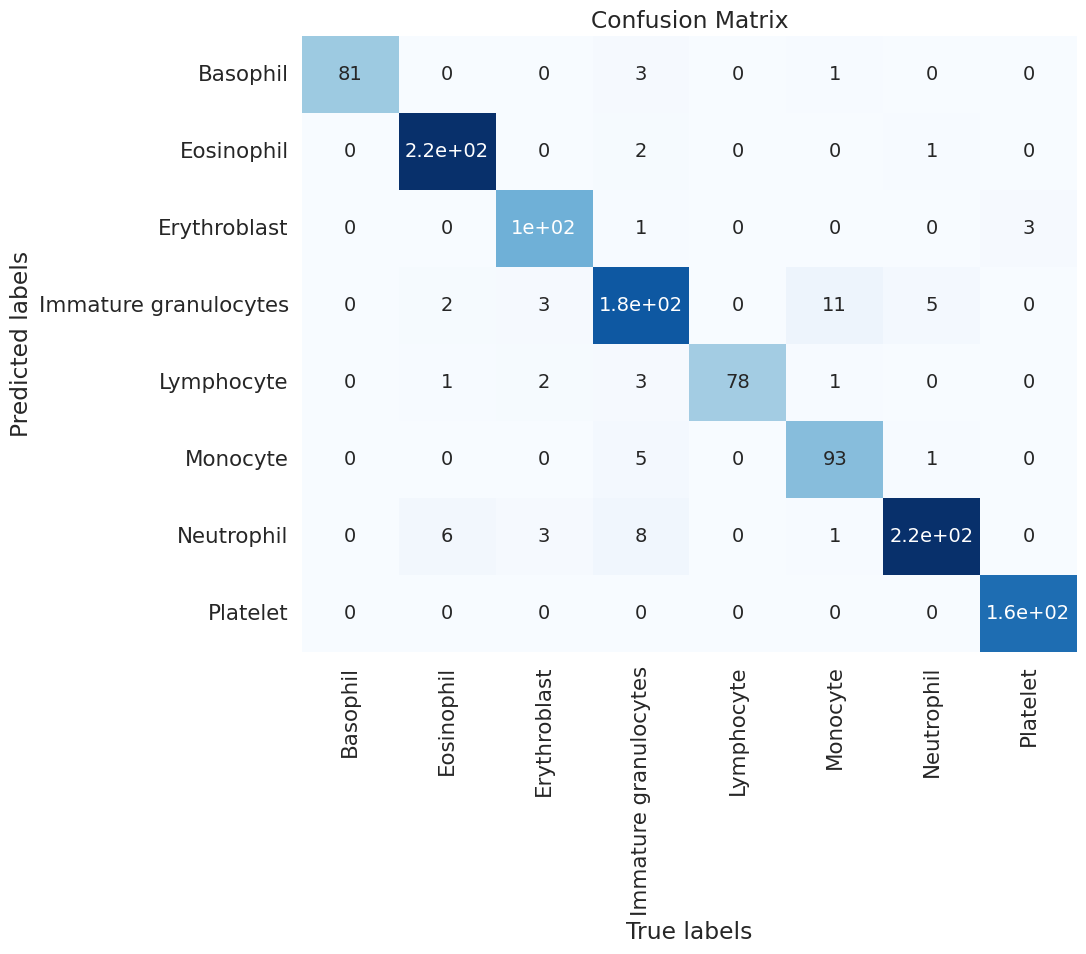

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert predictions and ground truth to class labels
pred_classes = np.argmax(predictions, axis=-1)
true_classes = np.argmax(y_test, axis=-1)

# Calculate and display metrics
accuracy = accuracy_score(true_classes, pred_classes)
precision = precision_score(true_classes, pred_classes, average='weighted')
recall = recall_score(true_classes, pred_classes, average='weighted')
f1 = f1_score(true_classes, pred_classes, average='weighted')

print(f'Accuracy score over the test set: {round(accuracy, 4)}')
print(f'Precision score over the test set: {round(precision, 4)}')
print(f'Recall score over the test set: {round(recall, 4)}')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, pred_classes)

# Define class labels (e.g., ['Class 0', 'Class 1', ...])
class_labels = labels  # Replace `labels` with your list of actual class names

# Plot the confusion matrix with class labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, xticklabels=class_labels, yticklabels=class_labels, cmap='Blues', cbar=False)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()


Above, we can see the results from the predictions made on the test dataset: the confusion matrix is shown and accuracy, precision, recall and F1 score are calculated

#####explainability

We generate and visualize a gradient map showing which parts of the image most influence the model's prediction: it helps to interpret and understand which regions of the image are important for the model's classification decision by displaying the gradient magnitude with respect to the predicted class

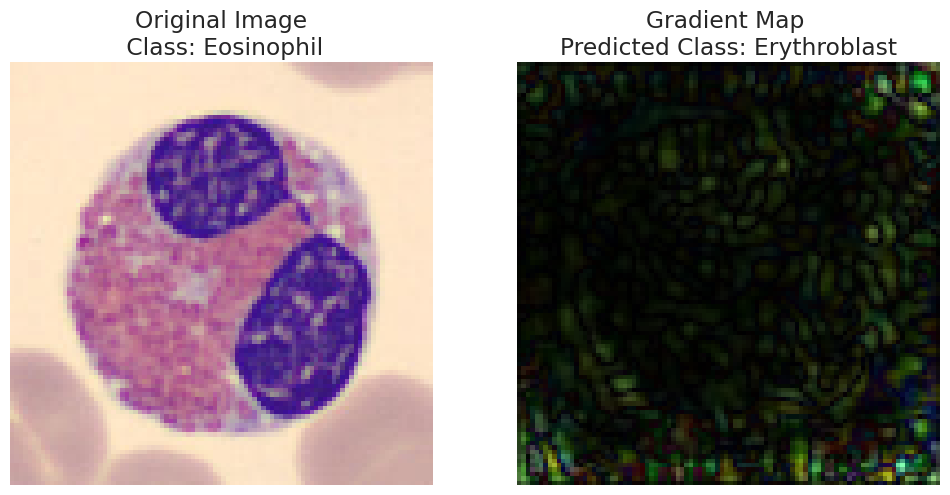

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Select one or more images from the test set
image_index = 81 # Change index to test other images
image = X_test[image_index: image_index + 1]  # Select a single image
true_class_index = np.argmax(y_test[image_index])

# Convert the image to a TensorFlow tensor
image = tf.convert_to_tensor(image, dtype=tf.float32)

# Get the model's predictions for the image
predictions = model.predict(image, verbose=0)

# Get the predicted class and associated probability
predicted_class = np.argmax(predictions)

# Calculate gradients with respect to the predicted class
with tf.GradientTape() as tape:
    tape.watch(image)
    preds = model(image)
    class_channel = preds[:, predicted_class]

grads = tape.gradient(class_channel, image)
grads = grads.numpy().squeeze()
grads = np.abs(grads)  # Absolute value to see all variations

# Normalize to obtain values between 0 and 1
grads -= grads.min()
grads /= grads.max()

# Display the results
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(image[0])
ax[0].set_title(f'Original Image\n Class: {labels[true_class_index]}')
ax[0].axis('off')

ax[1].imshow(grads, cmap='jet')
ax[1].set_title(f'Gradient Map \nPredicted Class: {labels[predicted_class]}')
ax[1].axis('off')

plt.show()

We perform feature extraction using the pre-trained model up to the flatten layer, comparing the extracted features of a test image with a subset of training images and displaying the test image alongside the five most similar images from the training set, based on feature distances
This helps visualize which images are most similar to a given test image by calculating distances between their features and ordering the training images accordingly

In [ ]:
# Explore the model structure to see the layer names
for layer in model.layers:
    print(layer.name, layer.__class__.__name__)

input_layer_1 InputLayer
vgg_preprocessing Lambda
vgg16 Functional
gap GlobalAveragePooling2D
dropout Dropout
dense Dense


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg_preprocessing (Lambda)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 3, 3, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gap (GlobalAveragePooling2D)         │ (None, 512)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 7,079,424 (27.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


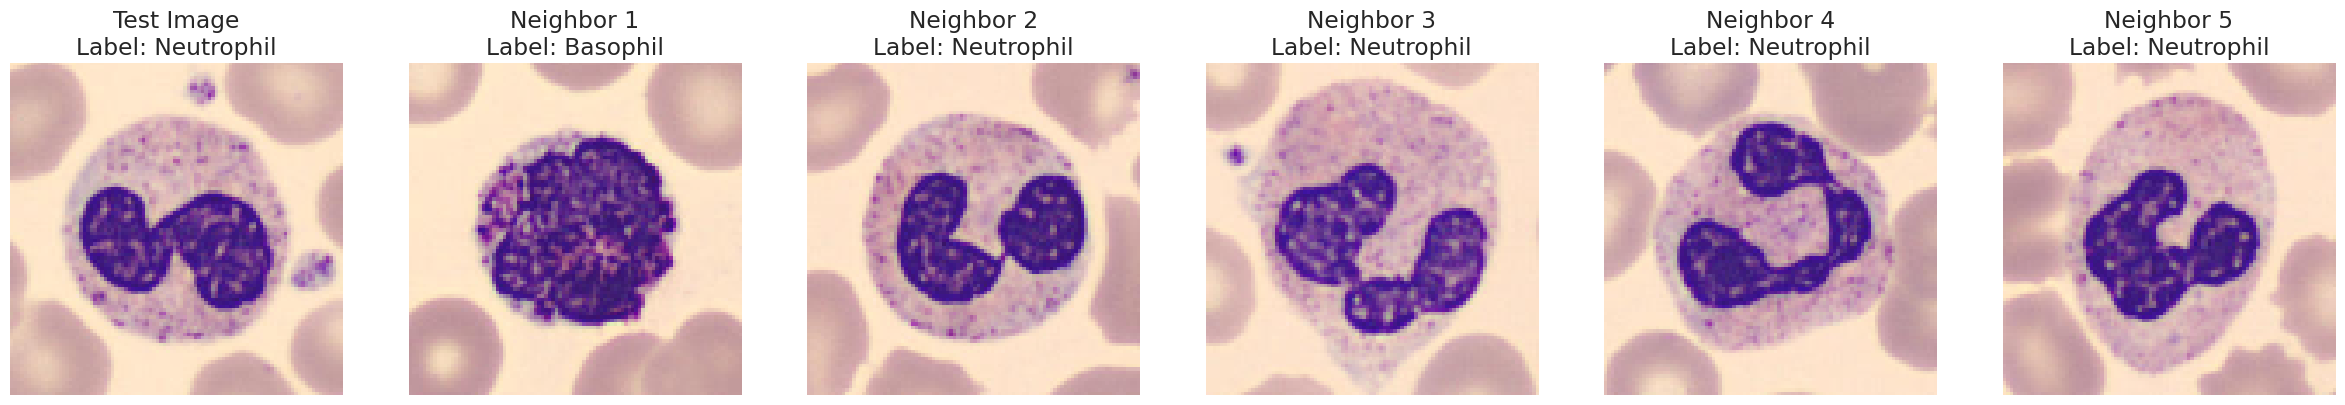

In [ ]:
from tensorflow.keras.models import Model

# Find the index of the last convolutional or max pooling layer you want to include
for i, layer in enumerate(model.layers):
    if 'gap' in layer.name:
        flatten_index = i

# Create a new model that includes only the layers up to the flatten layer
fen = Model(inputs=model.input, outputs=model.layers[flatten_index].output)

# Verify the architecture of the new model
fen.summary()

# Add a batch dimension to X_test[0]
idx_img=456
image_features = fen.predict(np.expand_dims(X_test[idx_img], axis=0))

X_train_sample = X_train_val
y_train_sample = y_train_val

# Convert labels from one-hot to categorical format
y_train_sample_categorical = np.argmax(y_train_sample, axis=1)
test_label_categorical = np.argmax(y_test[idx_img])

# Extract features for this subset
features = fen.predict(X_train_sample, batch_size=10, verbose=0)
distances = np.mean(np.abs(features - image_features), axis=-1)

# Get the indices sorted by distance
sorted_indices = distances.argsort()

# Use the sorted indices to select the images and labels
ordered_images = X_train_sample[sorted_indices]
ordered_labels = y_train_sample_categorical[sorted_indices]

# Display the test image and the 5 closest ones
plt.figure(figsize=(30, 10))

# Display the test image with its label
plt.subplot(1, 6, 1)
plt.imshow(X_test[idx_img])
plt.title(f"Test Image\nLabel: {labels[test_label_categorical]}")
plt.axis('off')

# Display the 5 closest images with their labels
for i in range(5):
    plt.subplot(1, 6, i + 2)
    plt.imshow(ordered_images[i])
    plt.title(f"Neighbor {i+1}\nLabel: {labels[ordered_labels[i]]}")
    plt.axis('off')

plt.show()

##🗂️preparing the submission

In [ ]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.applications.vgg16 import preprocess_input


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('VGG_15layers_96_29.keras', custom_objects={"preprocess_input": preprocess_input})

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Writing model.py


In [ ]:
#TEST
from model import Model
model = Model()
model.predict(X_test*256)

38/38 ━━━━━━━━━━━━━━━━━━━━ 164s 4s/step


array([2, 6, 1, ..., 0, 2, 1])

In [ ]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py VGG_15layers_96_29.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 55%)
  adding: VGG_15layers_96_29.keras (deflated 6%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>